In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Lambda

Using TensorFlow backend.


In [2]:
def import_data(csv): 
    
    df = pd.read_csv(csv)
    df.index = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df = df.drop('date', axis=1)
    
    close_columns = []
    high_columns = []
    low_columns = []
    open_columns = []
    volume_columns = []
    open_int_columns = []

    for i in df.columns:
        if "close" in i:
            close_columns.append(i)
        elif "high" in i:
            high_columns.append(i)
        elif "low" in i:
            low_columns.append(i)
        elif "open_int" in i:
            open_int_columns.append(i)
        elif "open" in i:
            open_columns.append(i)
        elif "volume" in i:
            volume_columns.append(i)

    close_df = df[close_columns]
    high_df = df[high_columns]
    low_df = df[low_columns]
    open_df = df[open_columns]
    volume_df = df[volume_columns]
    open_int_df = df[open_int_columns]
    
    return [close_df, high_df, low_df, open_df, volume_df, open_int_df]

def garman_klass_vol(high_df, low_df, close_df, open_df, period=60):
    """
    Estima a volatilidade a partir dos seguintes preços: alta, baixa, abertura e fechamento
    """
    # Calculando parcelas internas da somatoria
    x_hl = (1/2)*(np.log(np.divide(high_df, low_df))) ** 2
    x_co = - (2 * np.log(2) - 1)* (np.log(np.divide(close_df, open_df))**2)
    
    # Somando parcelas calculadas
    x = x_hl + x_co.values
    
    x.columns = [x[0:3] + "gk" for x in x.columns]
    
    # Criando dataframe para atribuir as volatilidades
    gk = x.copy()
    
    # Termo constante fora da somatoria (Considerando vol diaria)
    const = 1/period
    
    # Atribuindo not a number, para os valores iniciais
    gk.iloc[:period,:] = np.nan
    
    # iteração do centro de massa da vol
    for row in range(period, len(high_df)):
        gk.iloc[row] = np.sqrt(const * np.sum(x.iloc[row-period:row,:]))
        
    return gk

def parkinson_vol(high_df, low_df, period=60):
    """
    Estimando a volatilidade a partir dos preço de Alta e de Baixa
    """
    
    # Calculando parcela interna da somatoria
    x = np.log(np.divide(high_df, low_df)) ** 2
    x.columns = [x[0:3] + "pv" for x in x.columns]
    
    # Criando dataframe para atribuir as volatilidades
    pv = x.copy()
    
    # Termo constante fora da somatoria (Considerando vol diaria)
    const = 1 / (4 * period * np.log(2))
    
    # Atribuindo not a number, para os valores iniciais
    pv.iloc[:period,:] = np.nan
        
    # iteração do centro de massa da vol
    for row in range(period, len(high_df)):
        pv.iloc[row] = np.sqrt(const * np.sum(x.iloc[row-period:row,:]))
        
    return pv

def monthly_volume(volume, period=20):
    
    daily_volume = volume.copy()
    
    for row in range(period, len(volume)):
        daily_volume.iloc[row] = volume.iloc[row-period:row,:].cumsum().iloc[-1]
        
    monthly_volume = daily_volume.resample("BM").last().ffill()
    
    return monthly_volume

def train_test(stock):
    train = pd.DataFrame()

    train["Returns Monthly"] = returns_monthly.iloc[:,stock]
    train["EWMA"] = vol_monthly.iloc[:,stock]
    train["Parkinson"] = pv_monthly.iloc[:,stock]
    train["Garman-Klass"] = gk_monthly.iloc[:,stock]
    train["Monthly Volume"] = monthly_volume.iloc[:,stock]

    prices = close_df.iloc[:,stock]

    for lag in [3, 6, 9, 12]:
        train["Momentum " + str(lag)] = prices.pct_change(lag * 21)

    target = train["Returns Monthly"].shift(-1)
    
    features = train.dropna()
    target = target.dropna().loc['2000-07-31':]
    
    return (features, target)

In [3]:
close_df, high_df, low_df, open_df, volume_df, open_int_df = import_data("../data.csv")

# Retornos diários
returns_daily = close_df.pct_change().fillna(0)

# Retornos mensais
returns_monthly = close_df.pct_change(20).fillna(0).resample('BM').last().ffill()

# Vol diária
vol_daily = returns_daily.ewm(adjust=True, com=60, min_periods=0).std().dropna()

# Vol de 261 dias, apenas o último dia de cada mês
vol_monthly = (np.sqrt(261)*vol_daily).resample('BM').last().ffill()

pv_df = parkinson_vol(high_df, low_df)
pv_monthly = (np.sqrt(261)*pv_df).resample('BM').last().ffill()

gk_df = garman_klass_vol(high_df, low_df, close_df, open_df)
gk_monthly = (np.sqrt(261)*gk_df).resample('BM').last().ffill()

monthly_volume = monthly_volume(volume_df)

feature, target = train_test(1)

In [4]:
feature.head()

,Returns Monthly,EWMA,Parkinson,Garman-Klass,Monthly Volume,Momentum 3,Momentum 6,Momentum 9,Momentum 12
date,,,,,,,,,
2000-07-31,-0.013500,0.081672,0.090117,0.087723,135249.0,-0.051498,-0.084389,-0.095780,-0.052628
2000-08-31,-0.031493,0.076585,0.078957,0.080442,137686.0,-0.025209,-0.094248,-0.106080,-0.107423
2000-09-29,0.010879,0.095101,0.092941,0.094567,227772.0,-0.017524,-0.063966,-0.096061,-0.084917
2000-10-31,-0.010391,0.097895,0.104744,0.107019,101142.0,-0.045012,-0.090034,-0.116647,-0.124354
2000-11-30,-0.019273,0.092711,0.111326,0.112521,92974.0,-0.043417,-0.050007,-0.119602,-0.133054


In [5]:
model = Sequential()

model.add(Dense(200, input_shape=(9,), activation="sigmoid"))

model.add(Dense(100, activation="sigmoid"))

model.add(Dense(20, activation="sigmoid"))

model.add(Dense(1))

opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss="binary_crossentropy", optimizer=opt)

In [6]:
model.fit(feature[:180], target[:180], epochs=20)

Epoch 1/20
180/180 [==============================] - 1s 4ms/step - loss: 0.5262
Epoch 2/20
180/180 [==============================] - 0s 57us/step - loss: 0.3874
Epoch 3/20
180/180 [==============================] - 0s 55us/step - loss: 0.2688
Epoch 4/20
180/180 [==============================] - 0s 55us/step - loss: 0.1675
Epoch 5/20
180/180 [==============================] - 0s 89us/step - loss: 0.0798
Epoch 6/20
180/180 [==============================] - 0s 72us/step - loss: 0.0270
Epoch 7/20
180/180 [==============================] - 0s 61us/step - loss: 0.0270
Epoch 8/20
180/180 [==============================] - 0s 78us/step - loss: 0.0270
Epoch 9/20
180/180 [==============================] - 0s 78us/step - loss: 0.0270
Epoch 10/20
180/180 [==============================] - 0s 66us/step - loss: 0.0270
Epoch 11/20
180/180 [==============================] - 0s 61us/step - loss: 0.0270
Epoch 12/20
180/180 [==============================] - 0s 55us/step - loss: 0.0270
Epoch 13/20
18

In [44]:
def timeseries_to_supervised(data, lag=12):
    df = pd.DataFrame(data)
    columns = [df.pct_change(i) for i in range(1, lag*20, 10)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df

In [55]:
timeseries_to_supervised(close_df.iloc[1:,1]).dropna()

,BN_close,BN_close,BN_close,BN_close,BN_close,BN_close,BN_close,BN_close,BN_close,BN_close,...,BN_close,BN_close,BN_close,BN_close,BN_close,BN_close,BN_close,BN_close,BN_close,BN_close
date,,,,,,,,,,,,,,,,,,,,,
2000-06-20,0.003662,0.008389,0.016768,-0.026428,-0.044285,-0.048598,-0.034862,-0.042749,-0.048003,-0.063038,...,-0.087495,-0.081193,-0.067882,-0.055157,-0.060984,-0.058856,-0.043217,-0.027602,-0.046479,137.04
2000-06-21,-0.013135,-0.013926,0.010838,-0.040307,-0.056377,-0.061485,-0.049213,-0.049680,-0.067310,-0.072364,...,-0.093930,-0.092410,-0.086772,-0.075282,-0.066022,-0.068467,-0.051812,-0.033586,-0.053538,135.24
2000-06-22,0.010278,-0.005387,0.019171,-0.017616,-0.044011,-0.050191,-0.037478,-0.041597,-0.058438,-0.062509,...,-0.079747,-0.086698,-0.079189,-0.074636,-0.051839,-0.063793,-0.049332,-0.029754,-0.048736,136.63
2000-06-23,-0.007173,-0.005717,0.017706,-0.016102,-0.047870,-0.059684,-0.042561,-0.045256,-0.059945,-0.064612,...,-0.082888,-0.092399,-0.088006,-0.071971,-0.053252,-0.068210,-0.056217,-0.036645,-0.054836,135.65
2000-06-26,-0.003022,-0.006976,0.014630,-0.022409,-0.051014,-0.053869,-0.047740,-0.050147,-0.070324,-0.060638,...,-0.089170,-0.100020,-0.092410,-0.068916,-0.057824,-0.071919,-0.063435,-0.043361,-0.054728,135.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-17,-0.003561,-0.006235,-0.029969,-0.029894,-0.041781,-0.052667,-0.051097,-0.048155,-0.036428,-0.039222,...,-0.058124,-0.060934,-0.048731,-0.042510,-0.041635,-0.060373,-0.069883,-0.070363,-0.082556,125.91
2019-06-18,0.001588,-0.006617,-0.023614,-0.030818,-0.043317,-0.053868,-0.044476,-0.058881,-0.029400,-0.045561,...,-0.059161,-0.052446,-0.050734,-0.035930,-0.036519,-0.061123,-0.064466,-0.070054,-0.080160,126.11
2019-06-19,0.008564,-0.000707,-0.011195,-0.023193,-0.032923,-0.048833,-0.046266,-0.053364,-0.023868,-0.036366,...,-0.039350,-0.040872,-0.046552,-0.029158,-0.021766,-0.048478,-0.056174,-0.058828,-0.069909,127.19


In [56]:
close_df.iloc[:,0].shift(1).pct_change(30)['2000-06-20':]

date
2000-06-20    0.027836
2000-06-21    0.018233
2000-06-22    0.019840
2000-06-23   -0.001021
2000-06-26    0.020419
                ...   
2019-06-17   -0.021606
2019-06-18   -0.027605
2019-06-19   -0.026691
2019-06-20   -0.023466
2019-06-21   -0.011396
Name: AN_close, Length: 4383, dtype: float64

In [47]:
len(close_df.columns)

54

In [48]:
4383 * 53

232299

In [65]:
X = []
y = []



for column in close_df.columns:
    X.append(timeseries_to_supervised(close_df.iloc[1:,1]).dropna().to_numpy())
    y.append(close_df.iloc[:,0].shift(1).pct_change(30)['2000-06-20':].to_numpy())   

X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)

X = X.reshape((236682, 25))
y = y.reshape((236682, 1))

merge = pd.DataFrame(X)
merge['y'] = y

merge = merge.dropna()

X = merge.drop(['y'], axis=1)
y = merge['y']

(54, 4383, 25) (54, 4383)


In [112]:
y[0]

0.027835587929240457

In [67]:
split_time = 20000

# X = tf.keras.utils.normalize(X)
# y = tf.keras.utils.normalize(y)

X_train = X[30:split_time]
y_train = y[30:split_time]

X_test = X[split_time:]
y_test = y[split_time:]

In [79]:
X_train_norm = (X_train - X_train.mean()) / X_train.std()
X_test_norm = (X_test- X_train.mean()) / X_train.std()

In [100]:
model = Sequential()

units = 7

model.add(Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]))

model.add(LSTM(units, return_sequences=True))
#model.add(LSTM(units, return_sequences=True))
model.add(LSTM(units))

model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(5, activation='relu'))

model.add(Dense(1, activation='tanh'))

In [101]:
adam = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='mse', optimizer='adam')

In [102]:
history = model.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=20)

Train on 19970 samples, validate on 216682 samples
Epoch 1/20
19970/19970 [==============================] - 49s 2ms/step - loss: 0.0017 - val_loss: 0.0014TA: 3s - loss: 0.001 - 
Epoch 2/20
19970/19970 [==============================] - 50s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 3/20
19970/19970 [==============================] - 49s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/20
19970/19970 [==============================] - 47s 2ms/step - loss: 0.0010 - val_loss: 9.2022e-04
Epoch 5/20
19970/19970 [==============================] - 47s 2ms/step - loss: 9.4180e-04 - val_loss: 9.1222e-04
Epoch 6/20
19970/19970 [==============================] - 47s 2ms/step - loss: 8.9157e-04 - val_loss: 8.1596e-04
Epoch 7/20
19970/19970 [==============================] - 49s 2ms/step - loss: 8.5456e-04 - val_loss: 8.0025e-04
Epoch 8/20
19970/19970 [==============================] - 52s 3ms/step - loss: 8.2017e-04 - val_loss: 7.7819e-04
Epoch 9/20
19970/19970 [==========================

dict_keys(['val_loss', 'loss'])


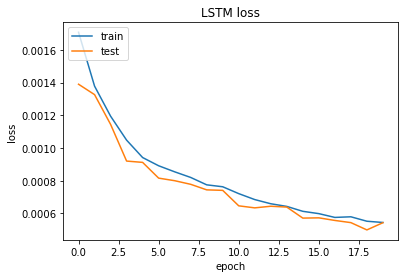

In [104]:
import matplotlib.pyplot as plt

print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [90]:
y_hat = model.predict(X_test_norm)

In [105]:
import seaborn as sns

C:\Users\lucas\anaconda3\envs\quant\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

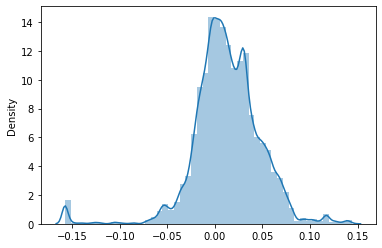

In [106]:
sns.distplot(y_hat)

C:\Users\lucas\anaconda3\envs\quant\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='y', ylabel='Density'>

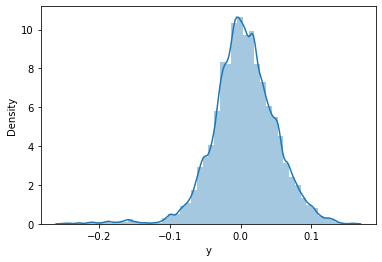

In [107]:
sns.distplot(y_test)

In [94]:
from sklearn.metrics import r2_score, mean_absolute_error

In [93]:
r2_score(y_test, y_hat)

0.5177355331666134

In [95]:
mean_absolute_error(y_test, y_hat)

0.02396129951831281